# Test notebook for pastas with Pest Solver

## Packages

In [1]:
from pathlib import Path
import pandas as pd

import pastas as ps
import pastas_plugins.pest as psp

if not "b" in ps.__version__:
    # https://github.com/pastas/pastas/pull/796 is required
    raise Exception("Please run Pastas on the dev branch")

## Load Data

In [2]:
head = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",index_col="date", parse_dates=True)
    .squeeze()
).iloc[-300:]
prec = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv", index_col="date", parse_dates=True)
    .squeeze()
)
evap = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv", index_col="date", parse_dates=True)
    .squeeze()
)
pex = (prec - evap).dropna().rename("PrecipitationExcess")

## Create Model

In [ ]:
ml = ps.Model(head, name="PestGLM")
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)
ml.add_stressmodel(sm)

# Solve with Pest GLM

In [3]:

pest_path = Path("pestf")
solver = psp.PestGlmSolver(
    exe_name="bin/pestpp-glm", model_ws=pest_path / "model", temp_ws=pest_path / "temp"
)
ml.solve(solver=solver)


2024-07-26 10:19:15.818872 starting: opening PstFrom.log for logging
2024-07-26 10:19:15.819140 starting PstFrom process
2024-07-26 10:19:15.819180 starting: setting up dirs
2024-07-26 10:19:15.819342 starting: removing existing new_d 'pestf/temp'
2024-07-26 10:19:15.823246 finished: removing existing new_d 'pestf/temp' took: 0:00:00.003904
2024-07-26 10:19:15.823368 starting: copying original_d 'pestf/model' to new_d 'pestf/temp'
2024-07-26 10:19:15.824677 finished: copying original_d 'pestf/model' to new_d 'pestf/temp' took: 0:00:00.001309
2024-07-26 10:19:15.825137 finished: setting up dirs took: 0:00:00.005957
2024-07-26 10:19:15.853065 transform was not passed, setting default tranform to 'log'
2024-07-26 10:19:15.853262 starting: adding grid type d style parameters for file(s) ['parameters_sel.csv']
2024-07-26 10:19:15.853442 starting: loading list-style pestf/temp/parameters_sel.csv
2024-07-26 10:19:15.853545 starting: reading list-style file: pestf/temp/parameters_sel.csv
2024-

[<Axes: xlabel='date', ylabel='Head'>,
 <Axes: xlabel='date'>,
 <Axes: title={'right': "Stresses: ['PrecipitationExcess']"}, xlabel='date', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=3)'}>]

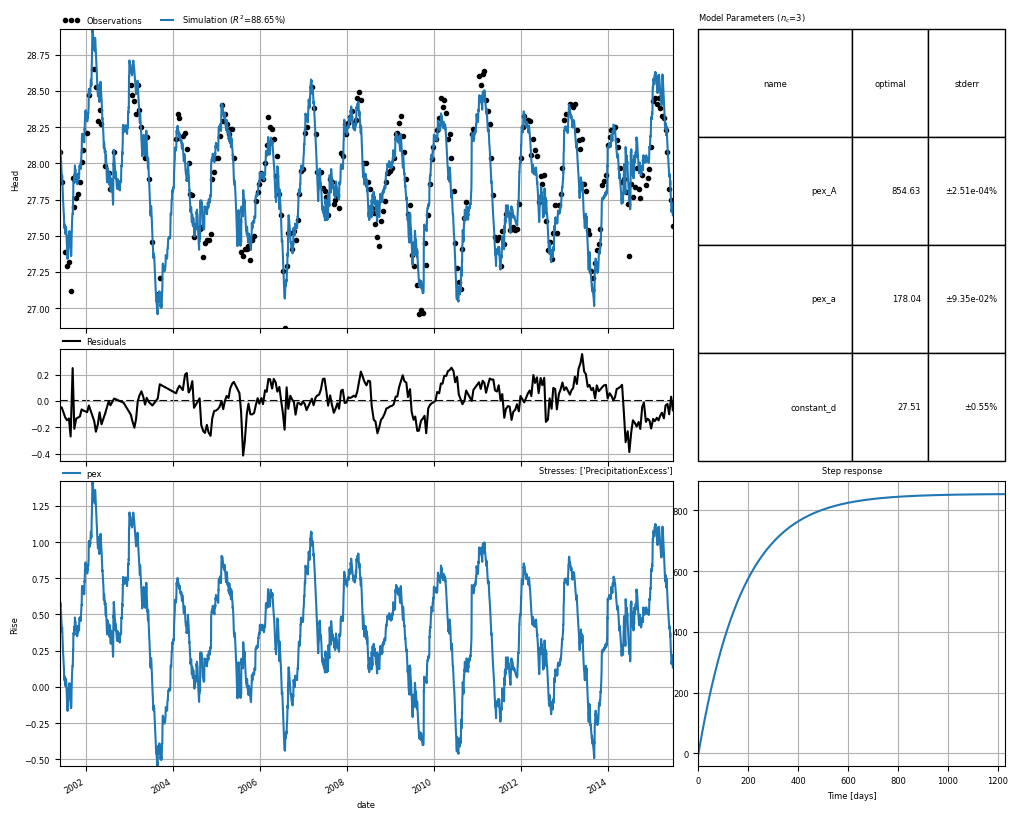

In [17]:
_ = ml.plots.results(stderr=True)

## Solve with SciPy Least Squares

Fit report LeastSquares           Fit Statistics
nfev    26                     EVP         88.65
nobs    300                    R2           0.89
noise   False                  RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1229.99
tmax    2015-06-28 00:00:00    BIC      -1218.96
freq    D                      Obj          2.44
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (3 optimized)
               optimal     initial  vary
pex_A       850.895010  215.674528  True
pex_a       177.192164   10.000000  True
constant_d   27.508802   27.902000  True


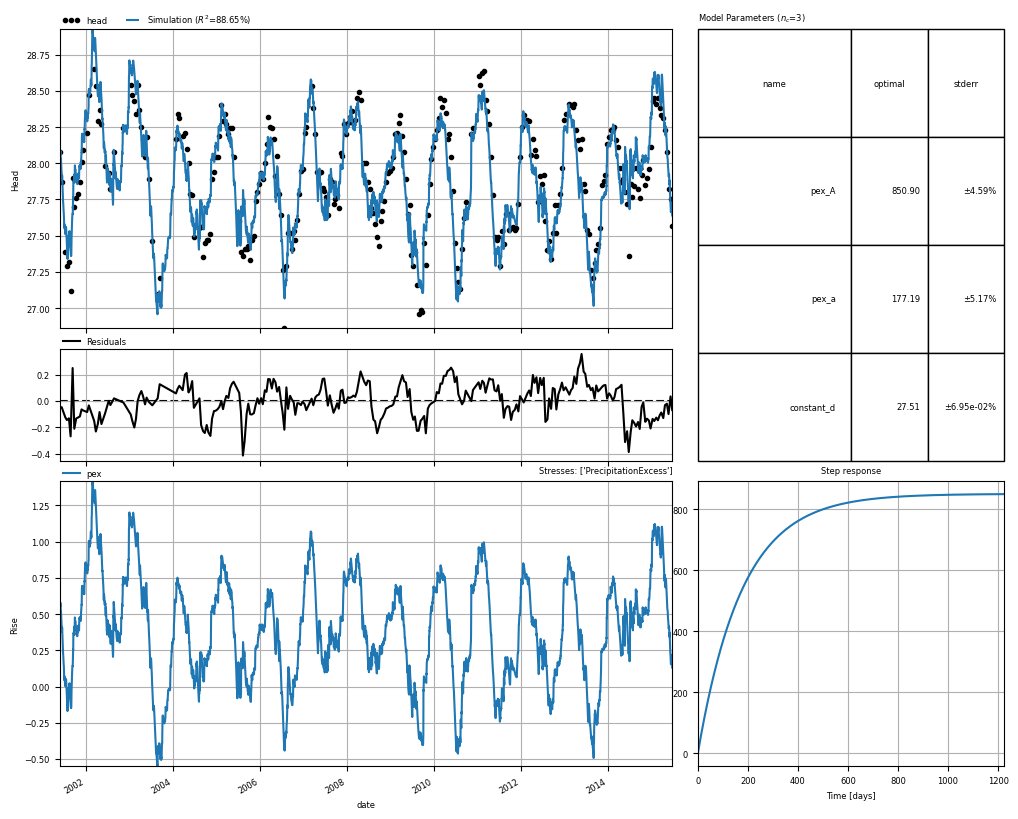

In [26]:
ml_ls = ml.copy()
ml_ls.name = "LeastSquares"
ml_ls.solve(solver=ps.LeastSquares())
_ = ml_ls.plots.results(stderr=True)

## Solve with Least Squares and AR1 NoiseModel

Fit report LSNoise                Fit Statistics
nfev    22                     EVP         88.58
nobs    300                    R2           0.89
noise   True                   RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1471.60
tmax    2015-06-28 00:00:00    BIC      -1456.92
freq    D                      Obj          1.08
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
                optimal     initial  vary
pex_A        875.512719  215.674528  True
pex_a        187.176393   10.000000  True
constant_d    27.497413   27.902000  True
noise_alpha   52.304410   14.000000  True


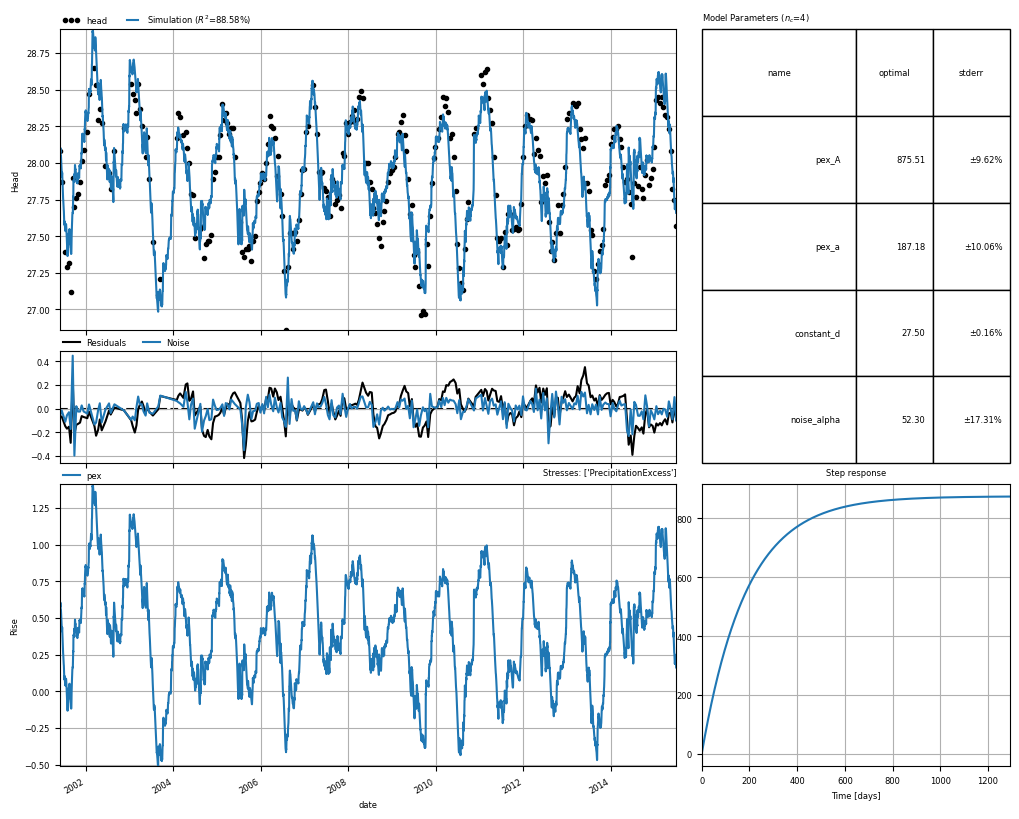

In [34]:
ml_lsn = ml.copy()
ml_lsn.name = "LSNoise"
ml_lsn.add_noisemodel(ps.ArNoiseModel())
ml_lsn.solve(solver=ps.LeastSquares())
_ = ml_lsn.plots.results(stderr=True)

## Compare Results

### Plot

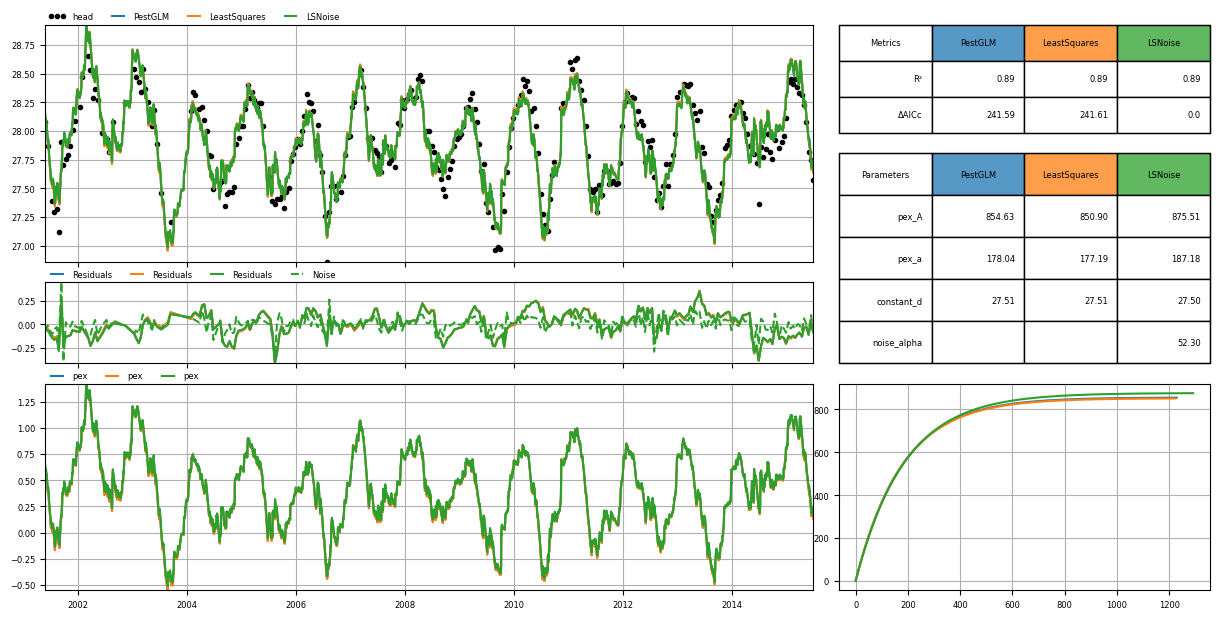

In [35]:
ps.plots.compare([ml, ml_ls, ml_lsn], figsize=(12, 6));

### Fit metrics

In [37]:
pd.concat([ml.stats.summary(), ml_ls.stats.summary(), ml_lsn.stats.summary()], axis=1, keys=[ml.name, ml_ls.name, ml_lsn.name])

,PestGLM,LeastSquares,LSNoise
,Value,Value,Value
Statistic,,,
rmse,0.127436,0.127439,0.127832
rmsn,NaN,NaN,0.084178
sse,4.871948,4.872242,4.902290
mae,0.103352,0.103322,0.103993
nse,0.886460,0.886453,0.885753
evp,88.646019,88.645334,88.575397
rsq,0.886460,0.886453,0.885753
kge,0.917353,0.916941,0.906428


### Parameters (and stderr)

In [39]:
pd.concat([ml.parameters.loc[:, ["optimal", "stderr"]], ml_ls.parameters.loc[:, ["optimal", "stderr"]], ml_lsn.parameters.loc[:, ["optimal", "stderr"]]], axis=1, keys=[ml.name, ml_ls.name, ml_lsn.name])

PestGLM           LeastSquares                LSNoise           
              optimal    stderr      optimal     stderr     optimal     stderr
pex_A        854.6310  0.002147   850.895010  39.066252  875.512719  84.204526
pex_a        178.0440  0.166463   177.192164   9.168716  187.176393  18.837881
constant_d    27.5071  0.150136    27.508802   0.019113   27.497413   0.043101
noise_alpha       NaN       NaN          NaN        NaN   52.304410   9.052760

### Covariance matrices

In [40]:
pd.concat([ml.solver.pcov, ml_ls.solver.pcov, ml_lsn.solver.pcov], axis=1, keys=[ml.name, ml_ls.name, ml_lsn.name])

PestGLM                      LeastSquares                             LSNoise                                    
                pex_A     pex_a constant_d        pex_A       pex_a constant_d        pex_A        pex_a constant_d noise_alpha
pex_A        0.000005 -0.000278  -0.000291  1526.172038  319.406440  -0.688453  7090.402243  1496.705688  -3.295146   45.092302
pex_a       -0.000278  0.027710   0.022031   319.406440   84.065354  -0.143179  1496.705688   354.865757  -0.694471    5.189364
constant_d  -0.000291  0.022031   0.022541    -0.688453   -0.143179   0.000365    -3.295146    -0.694471   0.001858   -0.021479
noise_alpha       NaN       NaN        NaN          NaN         NaN        NaN    45.092302     5.189364  -0.021479   81.952458